<a href="https://colab.research.google.com/github/dgrifka/nfl_motion_coverage_overlap/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Preparation**

We're going to save and train a neural network that predicts future player positions (trajectories) based on various game situations. The code for this notebook can be found at https://github.com/dgrifka/nfl_motion_coverage_overlap.

First, we must import the functions necessary.

In [ ]:
!git clone https://github.com/dgrifka/nfl_motion_coverage_overlap.git

import os

# Change this to the path of your repository
repo_path = '/content/nfl_motion_coverage_overlap'
os.chdir(repo_path)

# Import the necessary functions
%run setup.py

Cloning into 'nfl_motion_coverage_overlap'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 12), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 35.97 MiB | 32.88 MiB/s, done.
Resolving deltas: 100% (12/12), done.


You must have the "players", "games", "plays", "player_play", and "tracking_week" CSV files in your Google Drive. Another way to do this would be to upload the files manually to Colab.

If the files are in your Google Drive, then go ahead and mount your drive below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next, we're going to import and clean all the necessary data for the model.

Note: We're giong to use Polars vs Pandas simply because it's faster.

In [ ]:
players = read_nfl_csv('players')
players.head()

nflId,height,weight,birthDate,collegeName,position,displayName
i64,str,i64,str,str,str,str
25511,"""6-4""",225,"""1977-08-03""","""Michigan""","""QB""","""Tom Brady"""
29550,"""6-4""",328,"""1982-01-22""","""Arkansas""","""T""","""Jason Peters"""
29851,"""6-2""",225,"""1983-12-02""","""California""","""QB""","""Aaron Rodgers"""
30842,"""6-6""",267,"""1984-05-19""","""UCLA""","""TE""","""Marcedes Lewis"""
33084,"""6-4""",217,"""1985-05-17""","""Boston College""","""QB""","""Matt Ryan"""


In [ ]:
games = read_nfl_csv('games')
games.head()

gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
i64,i64,i64,str,str,str,str,i64,i64
2022090800,2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31
2022091100,2022,1,"""9/11/2022""","""13:00:00""","""ATL""","""NO""",26,27
2022091101,2022,1,"""9/11/2022""","""13:00:00""","""CAR""","""CLE""",24,26
2022091102,2022,1,"""9/11/2022""","""13:00:00""","""CHI""","""SF""",19,10
2022091103,2022,1,"""9/11/2022""","""13:00:00""","""CIN""","""PIT""",20,23


In [ ]:
plays_raw = read_nfl_csv('plays')
# Add team names and features, such as offense score differential
plays = process_nfl_plays(plays_raw, games)
plays.head()

gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,playClockAtSnap,passResult,passLength,targetX,targetY,playAction,dropbackType,dropbackDistance,passLocationType,timeToThrow,timeInTackleBox,timeToSack,passTippedAtLine,unblockedPressure,qbSpike,qbKneel,qbSneak,rushLocationType,penaltyYards,prePenaltyYardsGained,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,homeTeamAbbr,visitorTeamAbbr,offense_score_diff,game_time_left_mins,quarter_mins_left
i64,i64,str,i64,i64,i64,str,str,str,i64,str,i64,i64,str,i64,f64,f64,f64,str,str,i64,str,i64,f64,f64,bool,str,f64,str,f64,f64,f64,bool,bool,bool,i64,bool,str,i64,i64,i64,f64,f64,f64,bool,str,str,i64,str,str,str,str,i64,f64,f64
2022102302,2655,"""(1:54) (Shotgun) J.Burrow pass…",3,1,10,"""CIN""","""ATL""","""CIN""",21,"""01:54""",35,17,"""N""",31,0.982017,0.017983,0.719313,"""EMPTY""","""3x2""",10,"""C""",6,36.69,16.51,false,"""TRADITIONAL""",2.4,"""INSIDE_BOX""",2.99,2.99,null,false,false,false,0,null,null,null,9,9,0.004634,-0.004634,0.702717,true,null,null,0,"""Cover-3""","""Zone""","""CIN""","""ATL""",18,16.9,1.9
2022091809,3698,"""(2:13) (Shotgun) J.Burrow pass…",4,1,10,"""CIN""","""DAL""","""CIN""",8,"""02:13""",17,17,"""N""",18,0.424356,0.575644,0.607746,"""EMPTY""","""3x2""",9,"""C""",4,20.83,20.49,false,"""TRADITIONAL""",1.14,"""INSIDE_BOX""",1.836,1.836,null,false,false,false,0,null,null,null,4,4,0.002847,-0.002847,-0.240509,true,null,null,0,"""Quarters""","""Zone""","""DAL""","""CIN""",0,2.216667,2.216667
2022103004,3146,"""(2:00) (Shotgun) D.Mills pass …",4,3,12,"""HOU""","""TEN""","""HOU""",20,"""02:00""",3,17,"""N""",30,0.006291,0.993709,-0.291485,"""SHOTGUN""","""2x2""",12,"""C""",-4,26.02,17.56,false,"""TRADITIONAL""",3.2,"""INSIDE_BOX""",2.236,2.236,null,false,false,false,0,null,null,null,6,6,0.000205,-0.000205,-0.21848,true,null,null,0,"""Quarters""","""Zone""","""HOU""","""TEN""",-14,2.0,2.0
2022110610,348,"""(9:28) (Shotgun) P.Mahomes pas…",1,2,10,"""KC""","""TEN""","""TEN""",23,"""09:28""",0,0,"""N""",33,0.884223,0.115777,4.249382,"""SHOTGUN""","""2x2""",11,"""C""",-6,38.95,14.19,false,"""TRADITIONAL""",3.02,"""INSIDE_BOX""",2.202,2.202,null,false,false,false,0,null,null,null,4,4,-0.001308,0.001308,-0.427749,true,null,null,0,"""Quarters""","""Zone""","""KC""","""TEN""",0,54.466667,9.466667
2022102700,2799,"""(2:16) (Shotgun) L.Jackson up …",3,2,8,"""BAL""","""TB""","""TB""",27,"""02:16""",10,10,"""N""",37,0.410371,0.589629,3.928413,"""PISTOL""","""3x1""",8,"""""",null,null,null,true,"""DESIGNED_RUN""",2.03,null,null,null,null,null,null,null,0,false,"""INSIDE_LEFT""",null,-1,-1,0.027141,-0.027141,-0.638912,false,"""MAN""","""READ OPTION""",0,"""Cover-1""","""Man""","""TB""","""BAL""",0,17.266667,2.266667


In [ ]:
player_play = read_nfl_csv('player_play')
player_play.head()

gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,receivingYards,wasTargettedReceiver,yardageGainedAfterTheCatch,fumbles,fumbleLost,fumbleOutOfBounds,assistedTackle,forcedFumbleAsDefense,halfSackYardsAsDefense,passDefensed,quarterbackHit,sackYardsAsDefense,safetyAsDefense,soloTackle,tackleAssist,tackleForALoss,tackleForALossYardage,hadInterception,interceptionYards,fumbleRecoveries,fumbleRecoveryYards,penaltyYards,penaltyNames,wasInitialPassRusher,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,bool,f64,f64,bool,bool,bool,i64,str,i64,i64,str,i64,f64,str,i64,i64
2022090800,56,35472,"""BUF""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,false,null,null,false,false,false,null,null,47917,null,null,0,null,null,null,null
2022090800,56,42392,"""BUF""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,false,null,null,false,false,false,null,null,47917,null,null,0,null,null,null,null
2022090800,56,42489,"""BUF""",0,0,0,0,0,1,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,false,null,null,false,false,true,1,"""IN""",null,null,null,null,null,null,null,null
2022090800,56,44875,"""BUF""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,false,null,null,false,false,false,null,null,43335,null,null,0,null,null,null,null
2022090800,56,44985,"""BUF""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,false,null,null,false,false,false,1,"""OUT""",null,null,null,null,null,null,null,null


In [ ]:
# For post-snap data
post_snap = process_tracking_data(
    tracking_path=google_drive_path,
    snap_type="post",
    weeks=range(1, 10)
)

post_snap.head()

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str
2022090800,56,null,"""football""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",null,"""football""","""left""",85.160004,29.690001,0.0,0.0,0.0,null,null,null
2022090800,56,null,"""football""",148,"""AFTER_SNAP""","""2022-09-09 00:24:02.9""",null,"""football""","""left""",86.610001,30.15,8.19,1.64,1.53,null,null,null
2022090800,56,null,"""football""",149,"""AFTER_SNAP""","""2022-09-09 00:24:03""",null,"""football""","""left""",87.419998,30.15,7.81,4.85,0.81,null,null,null
2022090800,56,null,"""football""",150,"""AFTER_SNAP""","""2022-09-09 00:24:03.1""",null,"""football""","""left""",88.129997,30.15,7.21,6.49,0.71,null,null,null
2022090800,56,null,"""football""",151,"""AFTER_SNAP""","""2022-09-09 00:24:03.2""",null,"""football""","""left""",88.82,30.16,6.58,6.08,0.69,null,null,null


Now that we have the data loaded, we can calculate the average time to throw when a QB drops back.

In [ ]:
mean_ttt = calculate_mean_ttt(post_snap)
print(f"Mean time to throw: {mean_ttt} seconds")

Mean time to throw: 2.64706561922366 seconds


In [ ]:
# For post-snap data
post_snap_total = merge_tracking_data(post_snap, plays, players, add_team_column)
post_snap_total.head()

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,quarter,quarter_mins_left,offense_score_diff,game_time_left_mins,down,yardsToGo,absoluteYardlineNumber,offenseFormation,isDropback,pff_passCoverage,pff_manZone,position,team
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,i64,f64,i64,i64,i64,str,bool,str,str,str,str
2022090800,56,null,"""football""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",null,"""football""","""left""",85.160004,29.690001,0.0,0.0,0.0,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown"""
2022090800,56,null,"""football""",148,"""AFTER_SNAP""","""2022-09-09 00:24:02.9""",null,"""football""","""left""",86.610001,30.15,8.19,1.64,1.53,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown"""
2022090800,56,null,"""football""",149,"""AFTER_SNAP""","""2022-09-09 00:24:03""",null,"""football""","""left""",87.419998,30.15,7.81,4.85,0.81,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown"""
2022090800,56,null,"""football""",150,"""AFTER_SNAP""","""2022-09-09 00:24:03.1""",null,"""football""","""left""",88.129997,30.15,7.21,6.49,0.71,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown"""
2022090800,56,null,"""football""",151,"""AFTER_SNAP""","""2022-09-09 00:24:03.2""",null,"""football""","""left""",88.82,30.16,6.58,6.08,0.69,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown"""


In [ ]:
# Normalize x and y values, so that all plays are going left to right
post_snap_total_normalized = normalize_direction(post_snap_total)
post_snap_total_normalized.head()

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,quarter,quarter_mins_left,offense_score_diff,game_time_left_mins,down,yardsToGo,absoluteYardlineNumber,offenseFormation,isDropback,pff_passCoverage,pff_manZone,position,team,x_normalized,y_normalized,o_normalized,dir_normalized
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,i64,f64,i64,i64,i64,str,bool,str,str,str,str,f64,f64,f64,f64
2022090800,56,null,"""football""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",null,"""football""","""left""",85.160004,29.690001,0.0,0.0,0.0,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown""",34.839996,29.690001,null,null
2022090800,56,null,"""football""",148,"""AFTER_SNAP""","""2022-09-09 00:24:02.9""",null,"""football""","""left""",86.610001,30.15,8.19,1.64,1.53,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown""",33.389999,30.15,null,null
2022090800,56,null,"""football""",149,"""AFTER_SNAP""","""2022-09-09 00:24:03""",null,"""football""","""left""",87.419998,30.15,7.81,4.85,0.81,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown""",32.580002,30.15,null,null
2022090800,56,null,"""football""",150,"""AFTER_SNAP""","""2022-09-09 00:24:03.1""",null,"""football""","""left""",88.129997,30.15,7.21,6.49,0.71,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown""",31.870003,30.15,null,null
2022090800,56,null,"""football""",151,"""AFTER_SNAP""","""2022-09-09 00:24:03.2""",null,"""football""","""left""",88.82,30.16,6.58,6.08,0.69,null,null,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""",null,"""unknown""",31.18,30.16,null,null


In [ ]:
# Only frames before mean time to throw
passing_play_shortened = calculate_shortened_passing_plays(
    post_snap_total_normalized,
    mean_ttt
)
passing_play_shortened.head()

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,quarter,quarter_mins_left,offense_score_diff,game_time_left_mins,down,yardsToGo,absoluteYardlineNumber,offenseFormation,isDropback,pff_passCoverage,pff_manZone,position,team,x_normalized,y_normalized,o_normalized,dir_normalized,start_frame,time_elapsed
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,i64,f64,i64,f64,i64,i64,i64,str,bool,str,str,str,str,f64,f64,f64,f64,i64,f64
2022090800,56,35472,"""Rodger Saffold""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",76,"""BUF""","""left""",86.12,28.11,0.08,0.3,0.03,276.1,121.03,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""","""G""","""offense""",33.88,28.11,83.9,238.97,147,0.0
2022090800,56,44985,"""Isaiah McKenzie""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",6,"""BUF""","""left""",86.26,18.2,0.0,0.0,0.0,277.97,26.55,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""","""WR""","""offense""",33.74,18.2,82.03,333.45,147,0.0
2022090800,56,42392,"""Mitch Morse""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",60,"""BUF""","""left""",85.6,29.67,0.17,0.3,0.02,280.26,85.02,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""","""C""","""offense""",34.4,29.67,79.74,274.98,147,0.0
2022090800,56,42489,"""Stefon Diggs""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",14,"""BUF""","""left""",86.23,43.65,0.05,0.59,0.02,260.23,252.23,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""","""WR""","""offense""",33.77,43.65,99.77,107.77,147,0.0
2022090800,56,53522,"""Spencer Brown""",147,"""AFTER_SNAP""","""2022-09-09 00:24:02.8""",79,"""BUF""","""left""",86.15,32.86,0.27,1.26,0.02,251.46,109.09,null,1,15.0,0,60.0,1,10,85,"""SHOTGUN""",true,"""Cover 6-Left""","""Zone""","""T""","""offense""",33.85,32.86,108.54,250.91,147,0.0


Then, we want to create a dataframe with the football location at the start of the play. This is implemented in a feature, but also for the visualization.

In [ ]:
ball_df = get_initial_ball_position(passing_play_shortened)
ball_df.head()

gameId,playId,x_normalized,y_normalized
i64,i64,f64,f64
2022103001,3700,34.48,24.049999
2022103006,3519,63.82,24.48
2022110300,2580,41.709999,23.75
2022100902,3994,55.300003,25.709999
2022102302,970,76.089996,23.99


In [ ]:
# If you'd only like to train on a few games, then reduce the number below
n_games = 1000
# Get unique game IDs
game_ids = passing_play_shortened.select('gameId').unique().head(n_games)

In [ ]:
# Get defensive and offensive players
def_df = filter_players_by_position(passing_play_shortened, game_ids, 'defense')
off_df = filter_players_by_position(passing_play_shortened, game_ids, 'offense')

In [ ]:
# Add distance_from_football feature to both dataframes
def_df_with_distance = add_distance_from_football(def_df, ball_df)
off_df_with_distance = add_distance_from_football(off_df, ball_df)

After we've separated the data between offense and defense, we can create separate models for them.

In [ ]:
# Train defensive model
def_model, def_scaler_X, def_scaler_y, def_history = train_improved_route_predictor(
    def_df_with_distance,
    side='defense'
)

# Train offensive model
off_model, off_scaler_X, off_scaler_y, off_history = train_improved_route_predictor(
    off_df_with_distance,
    side='offense'
)

Preparing sequences for training...
Adding missing formation column: formation_UNDER_CENTER
Adding missing formation column: formation_NO_HUDDLE_SHOTGUN
Adding missing formation column: formation_NO_HUDDLE


100%|██████████| 78017/78017 [01:14<00:00, 1046.75it/s]


Epoch 1/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - loss: 0.1931 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 2/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0603 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 3/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0535 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0522 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 5/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0485 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 6/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0485 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 7/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0478 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 8/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0482 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 9/150
1947/1947 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0474 - val_lo

100%|██████████| 47861/47861 [00:46<00:00, 1030.50it/s]


Epoch 1/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.5051 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 2/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0734 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 3/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0605 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 4/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0578 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 5/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0546 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 6/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0521 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 7/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0494 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 8/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0515 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 9/150
1195/1195 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0490 - val_lo

Then, we save the model and download it to your local computer. From there, I was able to upload the model to GitHub to load in a separate Colab file.

In [ ]:
# Save
save_models_and_scalers(
    'offensive',
    off_model,
    off_scaler_X,
    off_scaler_y,
    off_history
)

save_models_and_scalers(
    'defensive',
    def_model,
    def_scaler_X,
    def_scaler_y,
    def_history
)

With the model, we can look at its predictions vs the actual routes that occurred. The validation loss is reasonable, while the model appears to capture future player routes relatively well.

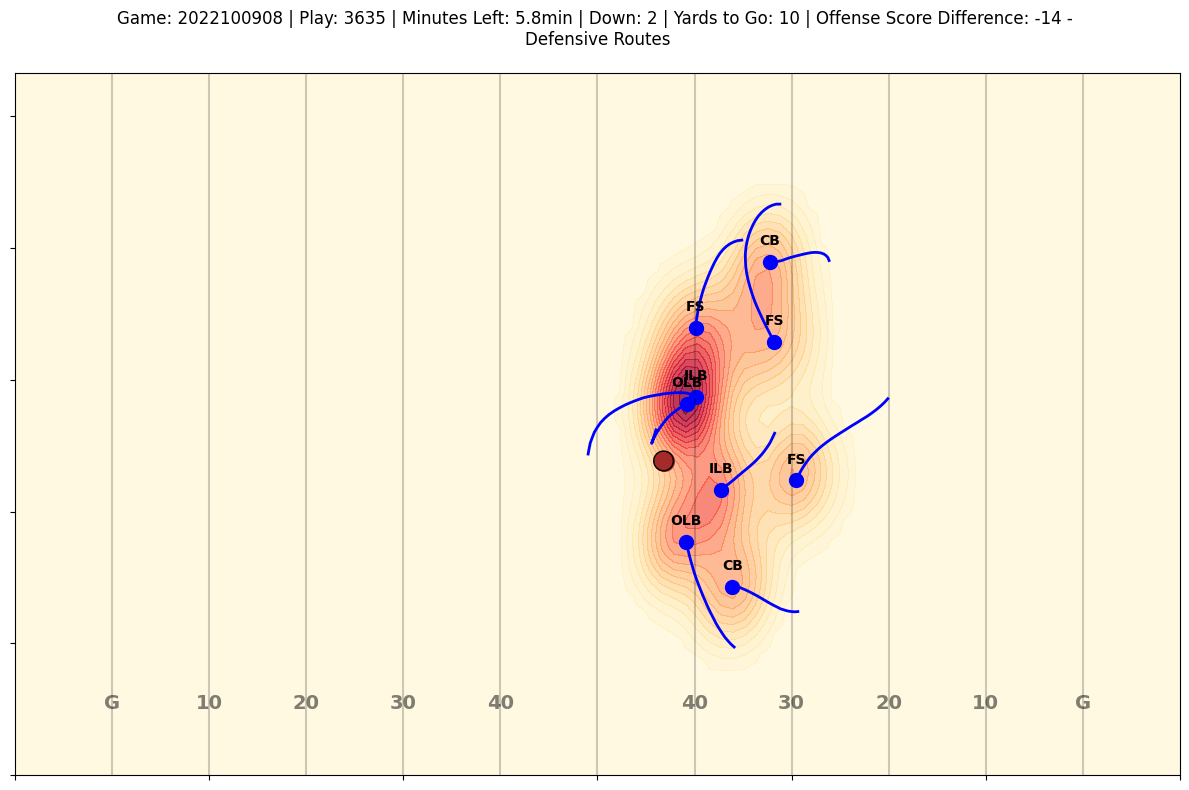

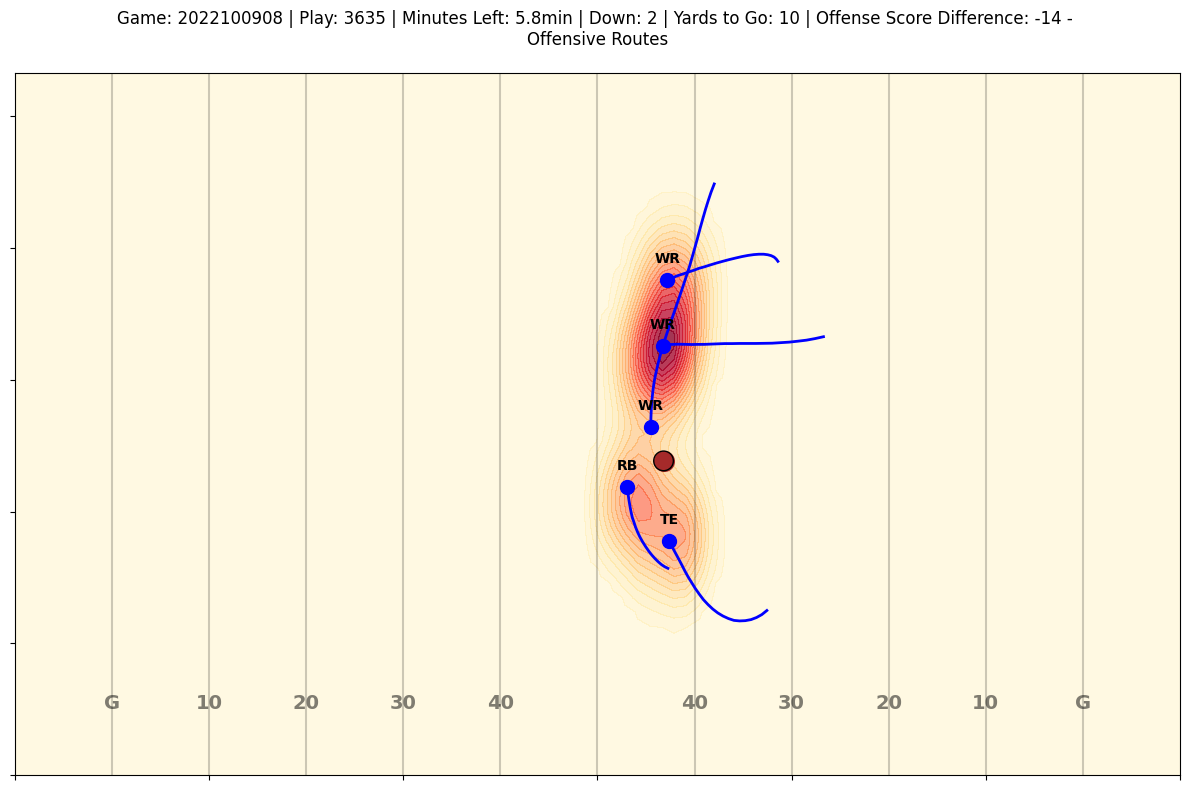

In [ ]:
# Analyze a specific play
game_id = 2022100908
play_id = 3635

# Get defensive predictions
def_predictions, def_routes = analyze_specific_play_by_side(
    def_df_with_distance,
    def_model,
    def_scaler_X,
    def_scaler_y,
    game_id,
    play_id,
    side='defense'
)

# Get offensive predictions
off_predictions, off_routes = analyze_specific_play_by_side(
    off_df_with_distance,
    off_model,
    off_scaler_X,
    off_scaler_y,
    game_id,
    play_id,
    side='offense'
)

Finally, we can take a look at the overlap of offense and defense location predictions.

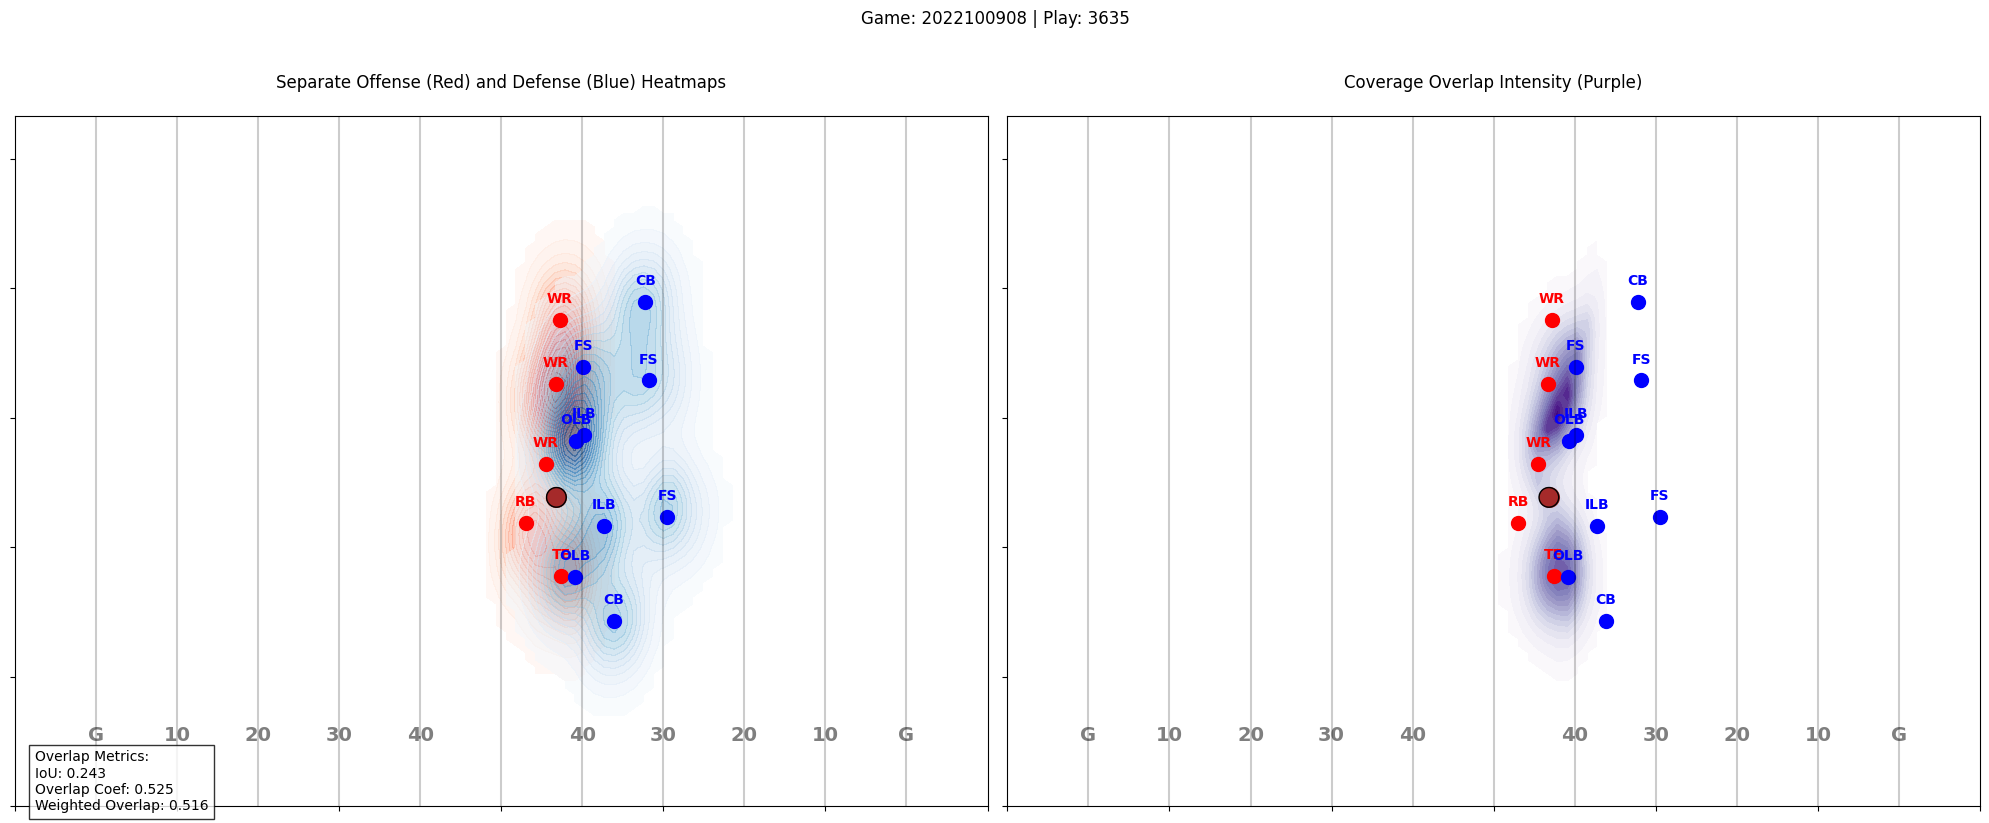

In [ ]:
# Get overlap visualization and metrics
overlap_metrics = plot_route_overlap(
    initial_positions_off=off_df_with_distance.filter(
        (pl.col('gameId') == game_id) &
        (pl.col('playId') == play_id)
    ).group_by('nflId').first().to_pandas(),
    initial_positions_def=def_df_with_distance.filter(
        (pl.col('gameId') == game_id) &
        (pl.col('playId') == play_id)
    ).group_by('nflId').first().to_pandas(),
    off_predictions=off_predictions,
    def_predictions=def_predictions,
    off_routes=off_routes,
    def_routes=def_routes,
    game_id=game_id,
    play_id=play_id
)